In [ ]:
import zipfile
import os
import warnings

import numpy as np
import pandas as pd
import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt
import missingno

In [ ]:
from data import *

In [ ]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 缺失值情况

In [ ]:
data_dir = r"data/"
fname_train = os.path.join(data_dir, "used_car_train_20200313.zip")
fname_testA = os.path.join(data_dir, "used_car_testA_20200313.zip")
data_train = extract_data(fname_train)
data_testA = extract_data(fname_testA)
data_train["notRepairedDamage"] = data_train["notRepairedDamage"].replace("-", np.nan)
data_testA["notRepairedDamage"] = data_testA["notRepairedDamage"].replace("-", np.nan)

In [ ]:
missingno.matrix(data_train.sample(1000))

In [ ]:
missingno.bar(data_train.sample(1000))

# 数据清洗
1. 删除高度倾斜的特征（无意义）
2. 缺失值处理
    - 缺失数据太多，删除该特征
    - 缺失数量可接受
        - 不处理。使用树模型
        - 插值：均值/众数/中位数
        - 多重插值？
        - 高维映射：
            - 感知压缩补全
            - 矩阵补全
        - 建模预测
        - 缺失值一个特殊标记（分箱）
3. 异常值处理
    - 箱线图或者3σ分析删除
    - BOX-COX转换（处理有偏分布）
    - 长尾截断
4. 数据分箱
    - 等频
    - 等距
    - Best-KS（类似基尼指数进行二分类）
    - 卡方分桶
5. 标准化
    - 正态分布
    - 均匀分析（0,1）
    - 幂律分布

In [ ]:
data_train, data_testA = load_data()
print(data_train.shape, data_testA.shape)

## 标签变换
回归问题`label`宜转换为正态分布。
- 无界约翰逊分布：`scipy.stats.johnsonsu`
- 正态分布：`scipy.stats.norm`
- log正态分布：`scipy.stats.lognorm`

In [ ]:
y = data_train["price"]
y.value_counts()

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.title("Johnson SU")
plt.figure(figsize=(8,6))
sns.distplot(y, kde=False, fit=st.norm)
plt.title("Normal")
plt.figure(figsize=(8,6))
sns.distplot(y, kde=False, fit=st.lognorm)
plt.title("Log Normal")

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(y)
plt.title("price原始分布")
plt.figure(figsize=(8,6))
plt.hist(np.log(y))
plt.title("price对数变换后分布")

In [ ]:
data_train["price"] = np.log(data_train["price"])

## 删除严重倾斜特征

In [ ]:
data_train.drop(["seller", "offerType"], axis=1, inplace=True)
data_testA.drop(["seller", "offerType"], axis=1, inplace=True)
print(data_train.shape, data_testA.shape)

## *特征情况*
- 类别特征看`boxplot`、`violinplot`
- 数值特征看`regplot`

In [13]:
print(data_train.dtypes.value_counts())
print(data_testA.dtypes.value_counts())

float64    18
int64      16
dtype: int64
float64    17
int64      16
dtype: int64


### 类别特征

In [14]:
data_train.select_dtypes(np.int64).columns

Index(['name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'notRepairedDamage', 'regionCode', 'creatDate', 'regYear', 'regMonth',
       'regDay', 'creatYear', 'creatMonth', 'creatDay'],
      dtype='object')

In [15]:
cat_cols = list(data_train.select_dtypes(np.int64).columns)
cat_cols.sort()
for col in cat_cols:
    print(f'{col} ： {data_train[col].nunique()}')

bodyType ： 9
brand ： 40
creatDate ： 96
creatDay ： 31
creatMonth ： 9
creatYear ： 2
fuelType ： 8
gearbox ： 3
model ： 249
name ： 99662
notRepairedDamage ： 3
regDate ： 3894
regDay ： 12
regMonth ： 13
regYear ： 25
regionCode ： 7905


<Figure size 720x1152 with 0 Axes>

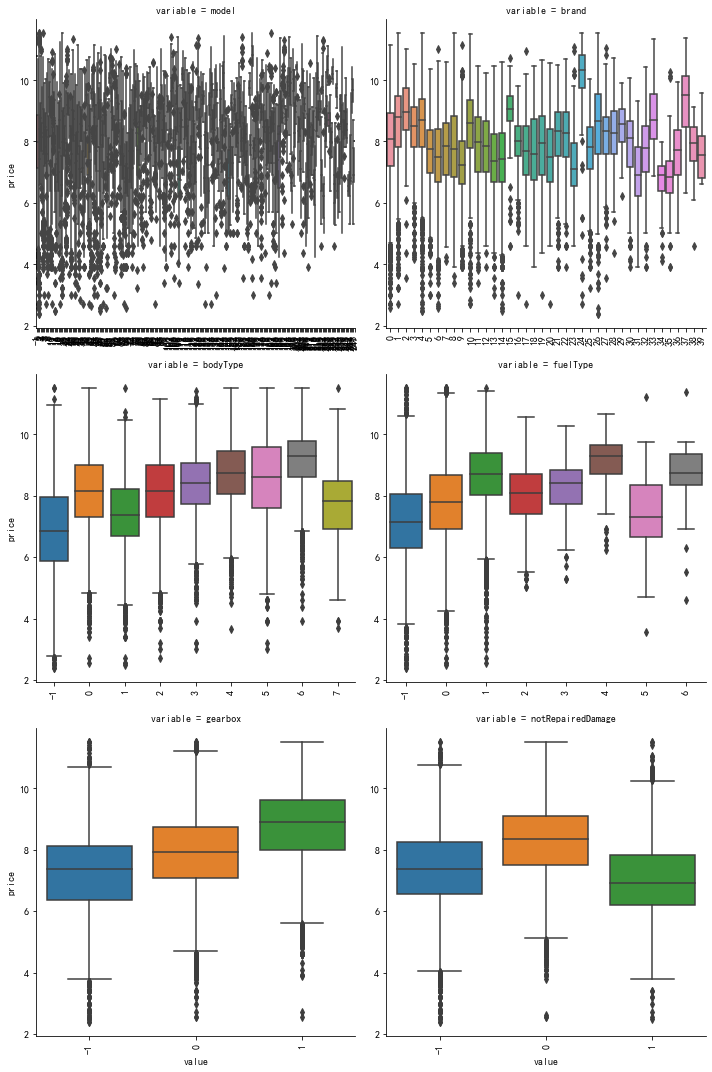

In [16]:
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    plt.xticks(rotation=90)

plt.figure(figsize=(10,16))
category_cols = ["model", "brand", "bodyType", "fuelType", "gearbox", "notRepairedDamage"]
f = pd.melt(data_train, value_vars=category_cols, id_vars="price")
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False, size=5)
g.map(boxplot, "value", "price")

<Figure size 720x1152 with 0 Axes>

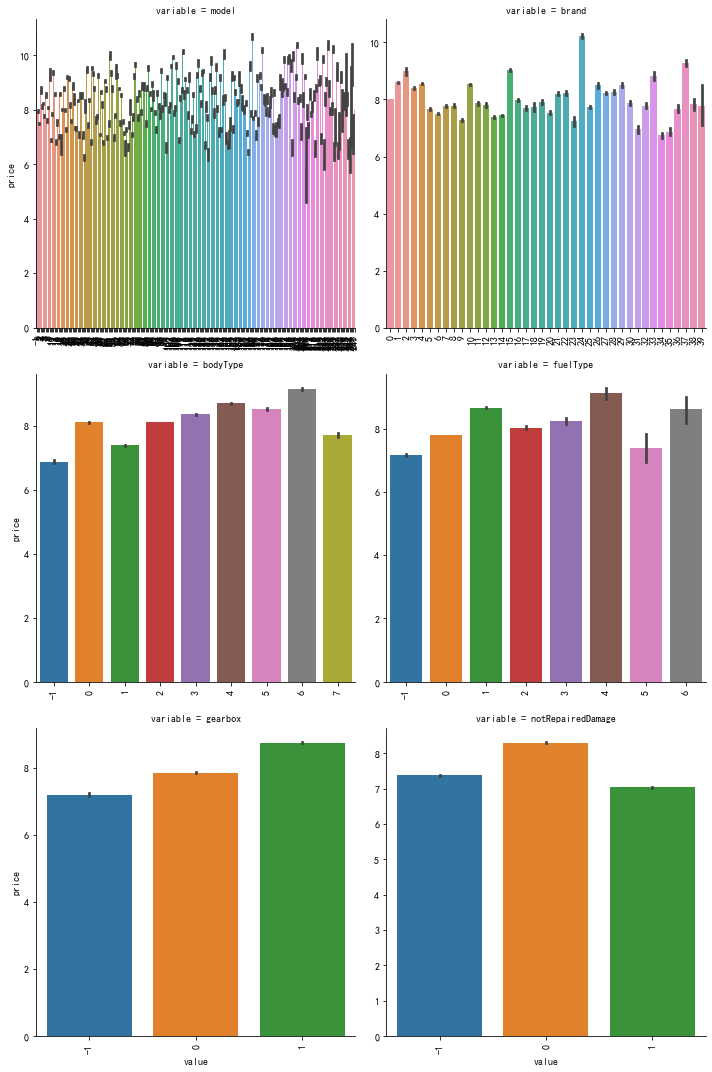

In [17]:
def barplot(x,y,**kwargs):
    sns.barplot(x=x,y=y)
    plt.xticks(rotation=90)

plt.figure(figsize=(10,16))
category_cols = ["model", "brand", "bodyType", "fuelType", "gearbox", "notRepairedDamage"]
f = pd.melt(data_train, value_vars=category_cols, id_vars="price")
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False, size=5)
g.map(barplot, "value", "price")

### 数值特征

In [18]:
num_cols = data_train.select_dtypes(np.float64).columns
num_cols

Index(['power', 'kilometer', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5',
       'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')

In [19]:
data_train[num_cols].corr()["price"].sort_values(ascending=False)

price        1.000000
v_8          0.833020
v_12         0.808428
v_0          0.780983
v_5          0.260403
power        0.216249
v_6          0.130683
v_1          0.126114
v_14         0.072143
v_13         0.039855
v_2          0.033446
v_7         -0.146771
v_4         -0.163415
v_9         -0.234548
v_10        -0.362207
v_11        -0.367326
kilometer   -0.377488
v_3         -0.927174
Name: price, dtype: float64

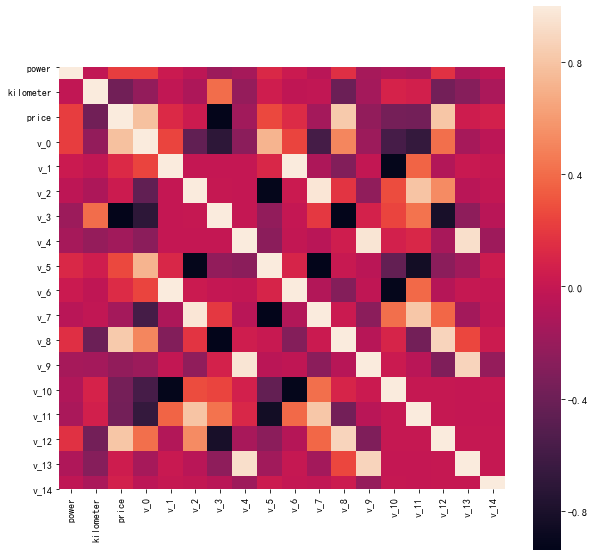

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(data_train[num_cols].corr(), square=True)

In [21]:
for col in num_cols:
    print("{:15}".format(col),
          "Skewness：{:5.2f}".format(data_train[col].skew()),
          "    ",
          "Kurtosis：{:7.2f}".format(data_train[col].kurt()))

power           Skewness：65.86      Kurtosis：5733.45
kilometer       Skewness：-1.53      Kurtosis：   1.14
price           Skewness：-0.27      Kurtosis：  -0.17
v_0             Skewness：-1.32      Kurtosis：   3.99
v_1             Skewness： 0.36      Kurtosis：  -1.75
v_2             Skewness： 4.84      Kurtosis：  23.86
v_3             Skewness： 0.11      Kurtosis：  -0.42
v_4             Skewness： 0.37      Kurtosis：  -0.20
v_5             Skewness：-4.74      Kurtosis：  22.93
v_6             Skewness： 0.37      Kurtosis：  -1.74
v_7             Skewness： 5.13      Kurtosis：  25.85
v_8             Skewness： 0.20      Kurtosis：  -0.64
v_9             Skewness： 0.42      Kurtosis：  -0.32
v_10            Skewness： 0.03      Kurtosis：  -0.58
v_11            Skewness： 3.03      Kurtosis：  12.57
v_12            Skewness： 0.37      Kurtosis：   0.27
v_13            Skewness： 0.27      Kurtosis：  -0.44
v_14            Skewness：-1.19      Kurtosis：   2.39


<Figure size 1152x1152 with 0 Axes>

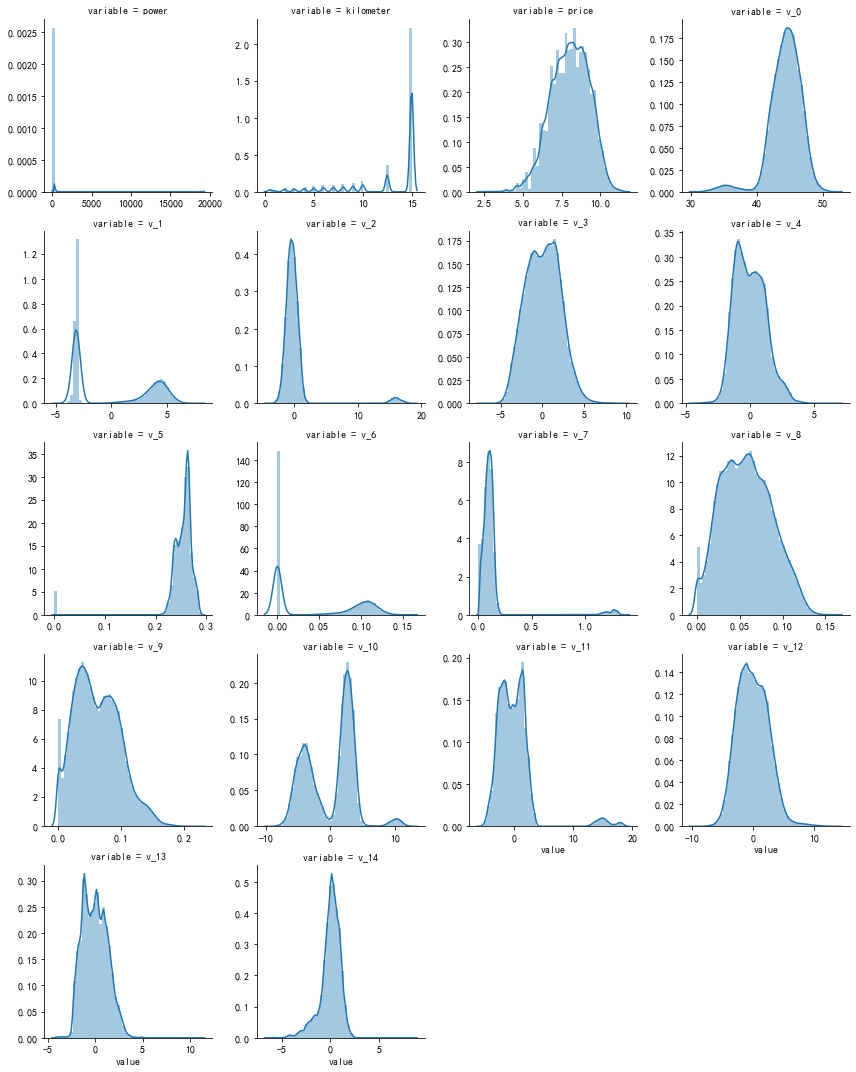

In [22]:
plt.figure(figsize=(16,16))
f = pd.melt(data_train, value_vars=num_cols)
g = sns.FacetGrid(f, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.distplot, "value")

In [23]:
len(num_cols)

18

In [24]:
num_cols[4]

'v_1'

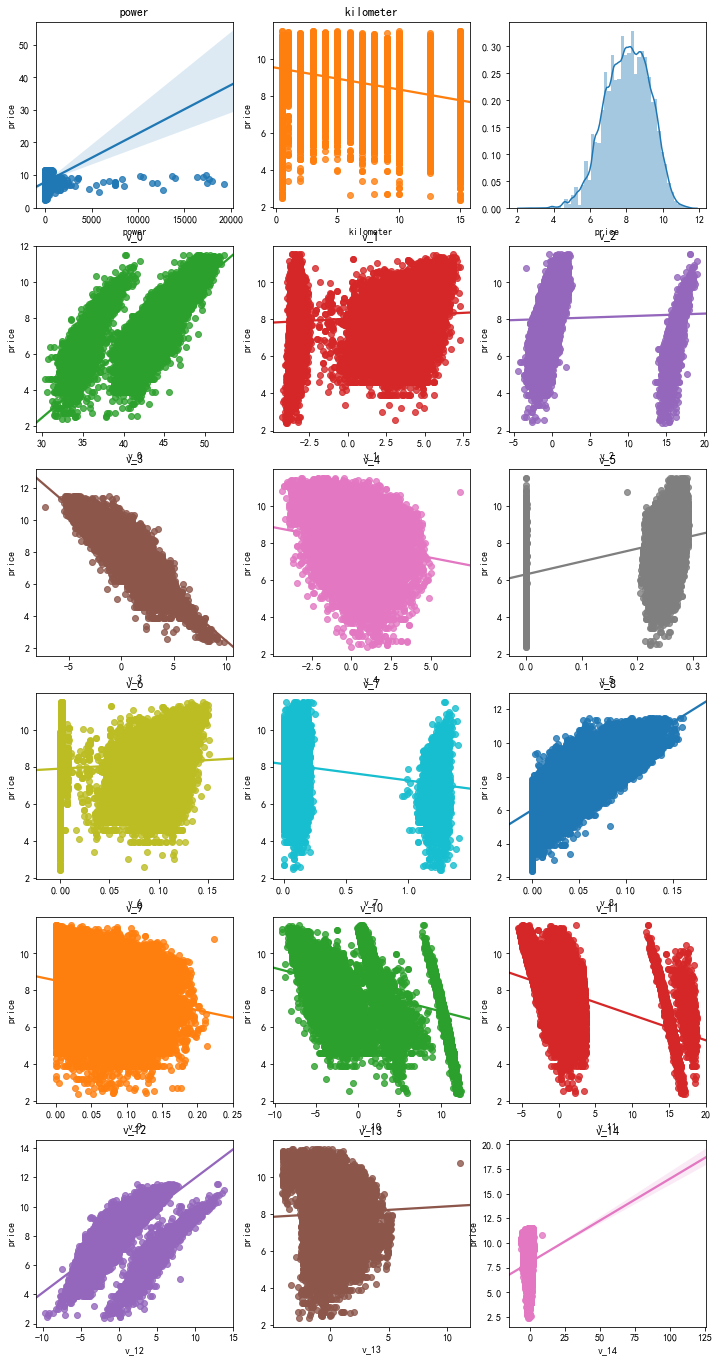

In [25]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 24))
axes = axes.flatten()
for i in range(18):
    col = num_cols[i]
    if col!="price":
        sns.regplot(data=data_train[[col, "price"]], x=col, y="price", scatter=True, fit_reg=True, ax=axes[i])
        axes[i].set_title(col)
    else:
        sns.distplot(data_train["price"], kde=True, ax=axes[i])

## 缺失值处理
- model、bodyType、fuelType、gearbox、notRepairedDamage有缺失值，
- `-1`代表缺失值；
- model仅在train中有一行缺失，

# 特征构造
1. 特征生成
    - 统计量特征
        - `count`
        - `sum`
        - `ratio`
        - `std`
    - 时间特征
        - 相对时间
        - 节假日
        - 双休日
        - 年/月/日
    - 空间特征
        - 分箱
        - 分布编码
2. 特征转换
    - 非线性变换
        - `log`
        - `power`
        - `sqrt`
    - 特征组合
    - 特征交叉

# 特征选择
- 过滤式：先对特征进行选择，然后训练模型
    - relief
    - 方差
    - 相关系数
    - 卡方检验
    - 互信息
- 包裹式：直接把最终要使用的模型的性能作为特征子集的评价准则
    - LVM
- 嵌入式：模型fit过程中自动进行特征选择
    - Lasso

# 降维
- PCA（无监督）
- LDA（有监督）
- LCA
- 特征选择